# Preprocessing Techniques with scikit-learn


Notebook didactique pour passer en revue les techniques principales de preprocessing avant l'entrainement d'un modele de machine learning.

Objectifs pedagogiques:
- comprendre quoi faire quand les donnees sont imparfaites (valeurs manquantes, outliers)
- savoir transformer les variables pour les rendre exploitables par un algorithme
- appliquer les bonnes pratiques scikit-learn pour eviter la fuite de donnees (data leakage)

Plan:
1. Data Cleaning
2. Preprocessing


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats

In [2]:
# Configuration pour les graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

In [3]:
# Création d'un dataset simple avec des animaux et leurs caractéristiques
data = {
    'animal': ['Chien', 'Chat', 'Cheval', 'Chien', 'Chat', 'Éléphant', 'Girafe', 'Chien', 'Cheval', 'Éléphant'],
    'couleur': ['Brun', 'Blanc', 'Noir', 'Noir', 'Roux', 'Gris', 'Jaune', 'Blanc', 'Brun', 'Gris'],
    'taille_cm': [60, 30, 180, 50, np.nan, 300, 500, 55, np.nan, 310],
    'poids_kg': [25, 4, 450, 20, 5, np.nan, 800, 22, 400, 5000],
    'age_annees': [5, 3, 12, 2, 7, 25, 10, np.nan, 8, 30],
    'vitesse_kmh': [40, 30, 70, 35, 32, 25, 50, 38, 75, 30]
}

# Création du DataFrame
df = pd.DataFrame(data)
print("Dataset original:")
df


Dataset original:


,animal,couleur,taille_cm,poids_kg,age_annees,vitesse_kmh
0,Chien,Brun,60.0,25.0,5.0,40
1,Chat,Blanc,30.0,4.0,3.0,30
2,Cheval,Noir,180.0,450.0,12.0,70
3,Chien,Noir,50.0,20.0,2.0,35
4,Chat,Roux,NaN,5.0,7.0,32
5,Éléphant,Gris,300.0,NaN,25.0,25
6,Girafe,Jaune,500.0,800.0,10.0,50
7,Chien,Blanc,55.0,22.0,NaN,38
8,Cheval,Brun,NaN,400.0,8.0,75
9,Éléphant,Gris,310.0,5000.0,30.0,30


## 1. DATA CLEANING

Cette section traite les problemes les plus frequents dans les donnees brutes:
- valeurs manquantes
- lignes/colonnes trop incompletes
- valeurs aberrantes (outliers)

Important: les decisions de nettoyage doivent etre justifiees par le contexte metier,
pas uniquement par une regle automatique.


### 1.1 Imputation simple (mean, median, mode)

Principe: remplacer les valeurs manquantes d'une variable par une statistique simple.

- mean: sensible aux outliers, utile si la distribution est plutot symetrique
- median: plus robuste aux valeurs extremes
- most_frequent (mode): pratique pour les variables categorielles ou tres discretes


In [4]:
print("\n1.1 Imputation simple (mean, median, mode)")
print("-------------------------------------------")

print("Valeurs manquantes (nombre):")
print(df.isnull().sum())

print("\nValeurs manquantes (pourcentage):")
print((df.isnull().mean() * 100).round(1).astype(str) + " %")



1.1 Imputation simple (mean, median, mode)
-------------------------------------------
Valeurs manquantes (nombre):
animal         0
couleur        0
taille_cm      2
poids_kg       1
age_annees     1
vitesse_kmh    0
dtype: int64

Valeurs manquantes (pourcentage):
animal          0.0 %
couleur         0.0 %
taille_cm      20.0 %
poids_kg       10.0 %
age_annees     10.0 %
vitesse_kmh     0.0 %
dtype: str


In [5]:
# Vue rapide des types: indispensable avant tout preprocessing
print("Apercu des types de colonnes:")
print(df.dtypes)


Apercu des types de colonnes:
animal             str
couleur            str
taille_cm      float64
poids_kg       float64
age_annees     float64
vitesse_kmh      int64
dtype: object


In [6]:
# Imputation par la moyenne sur les variables numeriques
imputer_mean = SimpleImputer(strategy='mean')
df_mean = df.copy()
df_mean[['taille_cm', 'poids_kg', 'age_annees']] = imputer_mean.fit_transform(
    df[['taille_cm', 'poids_kg', 'age_annees']]
)

print("Données brutes")
print(df[['taille_cm', 'poids_kg', 'age_annees']])

print("\nDonnées après imputation par la moyenne:")
print(df_mean[['taille_cm', 'poids_kg', 'age_annees']])
print("\nValeurs utilisees par l'imputer (mean):")
print(dict(zip(['taille_cm', 'poids_kg', 'age_annees'], np.round(imputer_mean.statistics_, 2))))


Données brutes
   taille_cm  poids_kg  age_annees
0       60.0      25.0         5.0
1       30.0       4.0         3.0
2      180.0     450.0        12.0
3       50.0      20.0         2.0
4        NaN       5.0         7.0
5      300.0       NaN        25.0
6      500.0     800.0        10.0
7       55.0      22.0         NaN
8        NaN     400.0         8.0
9      310.0    5000.0        30.0

Données après imputation par la moyenne:
   taille_cm     poids_kg  age_annees
0     60.000    25.000000    5.000000
1     30.000     4.000000    3.000000
2    180.000   450.000000   12.000000
3     50.000    20.000000    2.000000
4    185.625     5.000000    7.000000
5    300.000   747.333333   25.000000
6    500.000   800.000000   10.000000
7     55.000    22.000000   11.333333
8    185.625   400.000000    8.000000
9    310.000  5000.000000   30.000000

Valeurs utilisees par l'imputer (mean):
{'taille_cm': np.float64(185.62), 'poids_kg': np.float64(747.33), 'age_annees': np.float64(11.33)}


In [7]:
# Imputation par la mediane: souvent plus robuste en presence d'outliers
imputer_median = SimpleImputer(strategy='median')
df_median = df.copy()

df_median[['taille_cm', 'poids_kg', 'age_annees']] = imputer_median.fit_transform(
    df[['taille_cm', 'poids_kg', 'age_annees']]
)

print("\nDonnées après imputation par la médiane:")
print(df_median[['taille_cm', 'poids_kg', 'age_annees']])
print("\nValeurs utilisees par l'imputer (median):")
print(dict(zip(['taille_cm', 'poids_kg', 'age_annees'], np.round(imputer_median.statistics_, 2))))



Données après imputation par la médiane:
   taille_cm  poids_kg  age_annees
0       60.0      25.0         5.0
1       30.0       4.0         3.0
2      180.0     450.0        12.0
3       50.0      20.0         2.0
4      120.0       5.0         7.0
5      300.0      25.0        25.0
6      500.0     800.0        10.0
7       55.0      22.0         8.0
8      120.0     400.0         8.0
9      310.0    5000.0        30.0

Valeurs utilisees par l'imputer (median):
{'taille_cm': np.float64(120.0), 'poids_kg': np.float64(25.0), 'age_annees': np.float64(8.0)}


In [8]:
# Imputation par la valeur la plus frequente (mode)
imputer_mode = SimpleImputer(strategy='most_frequent')
df_mode = df.copy()
df_mode[['taille_cm', 'poids_kg', 'age_annees']] = imputer_mode.fit_transform(
    df[['taille_cm', 'poids_kg', 'age_annees']]
)

print("\nDonnées après imputation par le mode:")
print(df_mode[['taille_cm', 'poids_kg', 'age_annees']])
print("\nValeurs utilisees par l'imputer (most_frequent):")
print(dict(zip(['taille_cm', 'poids_kg', 'age_annees'], imputer_mode.statistics_)))



Données après imputation par le mode:
   taille_cm  poids_kg  age_annees
0       60.0      25.0         5.0
1       30.0       4.0         3.0
2      180.0     450.0        12.0
3       50.0      20.0         2.0
4       30.0       5.0         7.0
5      300.0       4.0        25.0
6      500.0     800.0        10.0
7       55.0      22.0         2.0
8       30.0     400.0         8.0
9      310.0    5000.0        30.0

Valeurs utilisees par l'imputer (most_frequent):
{'taille_cm': np.float64(30.0), 'poids_kg': np.float64(4.0), 'age_annees': np.float64(2.0)}


### 1.2 KNN Imputer

Le KNNImputer remplace une valeur manquante en utilisant les k voisins les plus proches
(observations similaires sur les autres variables numeriques).

Idee cle: l'imputation depend du voisinage local, pas d'une statistique globale.


In [9]:
# Exemple avec KNN Imputer (n_neighbors=3)
imputer_knn = KNNImputer(n_neighbors=3)
df_knn = df.copy()
numeric_cols = ['taille_cm', 'poids_kg', 'age_annees', 'vitesse_kmh']
df_knn[numeric_cols] = imputer_knn.fit_transform(df[numeric_cols])

print("Données après imputation par KNN (n_neighbors=3):")
print(df_knn[numeric_cols])

# Comparaison rapide sur les lignes qui contenaient au moins un NaN
nan_rows = df[numeric_cols].isna().any(axis=1)
print("\nComparaison avant/apres sur les lignes incompletes:")
print(pd.concat([
    df.loc[nan_rows, numeric_cols].add_prefix('avant_'),
    df_knn.loc[nan_rows, numeric_cols].add_prefix('apres_')
], axis=1))


Données après imputation par KNN (n_neighbors=3):
    taille_cm     poids_kg  age_annees  vitesse_kmh
0   60.000000    25.000000    5.000000         40.0
1   30.000000     4.000000    3.000000         30.0
2  180.000000   450.000000   12.000000         70.0
3   50.000000    20.000000    2.000000         35.0
4   46.666667     5.000000    7.000000         32.0
5  300.000000  1801.666667   25.000000         25.0
6  500.000000   800.000000   10.000000         50.0
7   55.000000    22.000000    4.666667         38.0
8  180.000000   400.000000    8.000000         75.0
9  310.000000  5000.000000   30.000000         30.0

Comparaison avant/apres sur les lignes incompletes:
   avant_taille_cm  avant_poids_kg  avant_age_annees  avant_vitesse_kmh  \
4              NaN             5.0               7.0                 32   
5            300.0             NaN              25.0                 25   
7             55.0            22.0               NaN                 38   
8              NaN       

### 1.3 Suppression de lignes et colonnes avec trop de valeurs manquantes

Quand une observation (ligne) ou une variable (colonne) contient trop de valeurs manquantes,
il peut etre plus pertinent de la supprimer plutot que d'imputer.

Le seuil (30% ici) doit etre adapte au volume de donnees et a l'importance metier des variables.


In [10]:
print("\n1.3 Suppression de lignes et colonnes avec trop de valeurs manquantes")
print("--------------------------------------------------------------------")

# On cree un cas plus degrade pour illustrer la logique
df_na = df.copy()
df_na.loc[2:5, 'vitesse_kmh'] = np.nan
df_na.loc[7:8, 'poids_kg'] = np.nan
print("Dataset avec plus de valeurs manquantes:")
print(df_na.isnull().sum())

print("\nValeurs manquantes (pourcentage):")
print((df_na.isnull().mean() * 100).round(1).astype(str) + " %")

missing_threshold = 0.30

# Suppression des lignes avec > 30% de valeurs manquantes
df_drop_rows = df_na.dropna(thresh=df_na.shape[1] * (1 - missing_threshold))
print("\nSuppression des lignes avec > 30% de valeurs manquantes:")
print(f"Avant: {df_na.shape[0]} lignes, Après: {df_drop_rows.shape[0]} lignes")

# Suppression des colonnes avec > 30% de valeurs manquantes
df_drop_cols = df_na.dropna(axis=1, thresh=df_na.shape[0] * (1 - missing_threshold))
print("\nSuppression des colonnes avec > 30% de valeurs manquantes:")
print(f"Avant: {df_na.shape[1]} colonnes, Après: {df_drop_cols.shape[1]} colonnes")
print(f"Colonnes supprimées: {set(df_na.columns) - set(df_drop_cols.columns)}")



1.3 Suppression de lignes et colonnes avec trop de valeurs manquantes
--------------------------------------------------------------------
Dataset avec plus de valeurs manquantes:
animal         0
couleur        0
taille_cm      2
poids_kg       3
age_annees     1
vitesse_kmh    4
dtype: int64

Valeurs manquantes (pourcentage):
animal          0.0 %
couleur         0.0 %
taille_cm      20.0 %
poids_kg       30.0 %
age_annees     10.0 %
vitesse_kmh    40.0 %
dtype: str

Suppression des lignes avec > 30% de valeurs manquantes:
Avant: 10 lignes, Après: 6 lignes

Suppression des colonnes avec > 30% de valeurs manquantes:
Avant: 6 colonnes, Après: 5 colonnes
Colonnes supprimées: {'vitesse_kmh'}


### 1.4 Traitement des outliers

Deux approches courantes:
- Z-Score: compare l'ecart a la moyenne en nombre d'ecarts-types
- IQR: repere les valeurs hors de l'intervalle [Q1 - 1.5*IQR, Q3 + 1.5*IQR]

A noter: supprimer un outlier n'est pas toujours la bonne option. Selon le cas, on peut aussi
clipper, transformer (log), ou utiliser un modele robuste.


In [11]:
print("\n1.4 Traitement des outliers")
print("-------------------------")

# On part d'un dataset impute pour eviter que les NaN perturbent le calcul
df_outliers = df_mean.copy()
df_outliers.loc[9, 'poids_kg'] = 9000
df_outliers.loc[8, 'age_annees'] = 40

print("Dataset avec outliers:")
print(df_outliers[['taille_cm', 'poids_kg', 'age_annees']])



1.4 Traitement des outliers
-------------------------
Dataset avec outliers:
   taille_cm     poids_kg  age_annees
0     60.000    25.000000    5.000000
1     30.000     4.000000    3.000000
2    180.000   450.000000   12.000000
3     50.000    20.000000    2.000000
4    185.625     5.000000    7.000000
5    300.000   747.333333   25.000000
6    500.000   800.000000   10.000000
7     55.000    22.000000   11.333333
8    185.625   400.000000   40.000000
9    310.000  9000.000000   30.000000


#### Methode 1: Z-Score

Regle classique: on considere qu'une observation est atypique si |z| > 3.


In [12]:
print("\nDétection des outliers avec Z-Score (|z| > 3):")
z_scores = stats.zscore(df_outliers[['taille_cm', 'poids_kg', 'age_annees']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_z_filtered = df_outliers[filtered_entries]

outlier_indices_z = df_outliers.index[~filtered_entries].tolist()
print(f"Outliers détectés par Z-Score: {(~filtered_entries).sum()} observations")
print(f"Index des outliers (Z-Score): {outlier_indices_z}")
print(f"Nouvelles dimensions: {df_z_filtered.shape}")



Détection des outliers avec Z-Score (|z| > 3):
Outliers détectés par Z-Score: 0 observations
Index des outliers (Z-Score): []
Nouvelles dimensions: (10, 6)


#### Methode 2: IQR (Interquartile Range)

Approche robuste qui depend des quartiles plutot que de la moyenne/ecart-type.



Détection des outliers avec IQR (1.5 * IQR):
Outliers détectés par IQR: 1 observations
Index des outliers (IQR): [9]
Nouvelles dimensions: (9, 6)


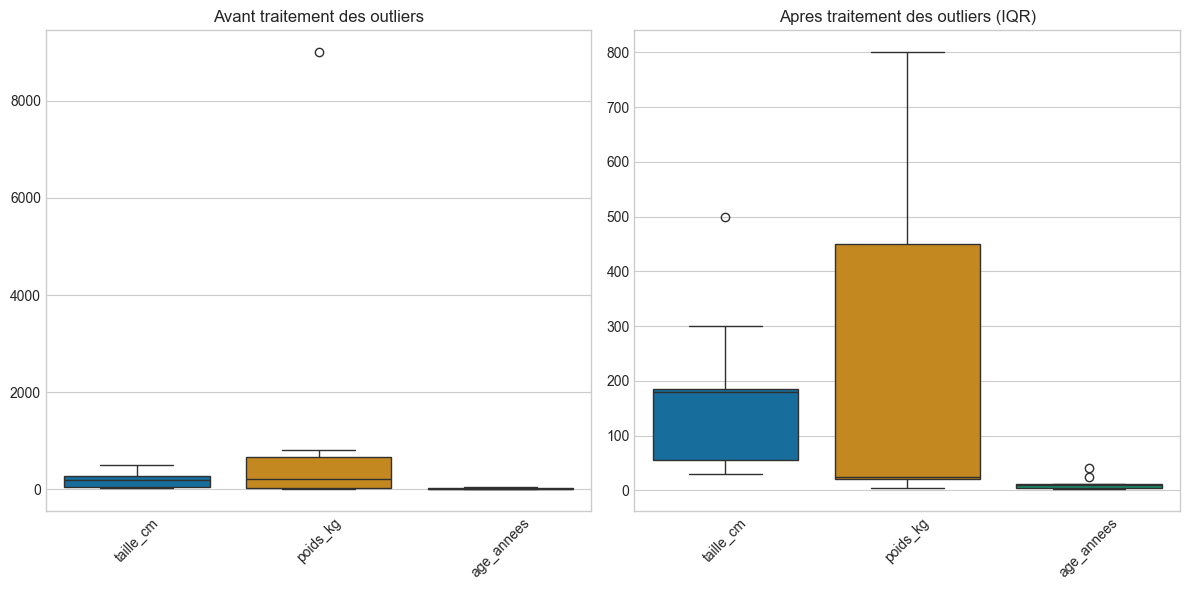

In [13]:
print("\nDétection des outliers avec IQR (1.5 * IQR):")
Q1 = df_outliers[['taille_cm', 'poids_kg', 'age_annees']].quantile(0.25)
Q3 = df_outliers[['taille_cm', 'poids_kg', 'age_annees']].quantile(0.75)
IQR = Q3 - Q1

outlier_mask = ((df_outliers[['taille_cm', 'poids_kg', 'age_annees']] < (Q1 - 1.5 * IQR)) |
                (df_outliers[['taille_cm', 'poids_kg', 'age_annees']] > (Q3 + 1.5 * IQR))).any(axis=1)

df_iqr_filtered = df_outliers[~outlier_mask]
outlier_indices_iqr = df_outliers.index[outlier_mask].tolist()
print(f"Outliers détectés par IQR: {outlier_mask.sum()} observations")
print(f"Index des outliers (IQR): {outlier_indices_iqr}")
print(f"Nouvelles dimensions: {df_iqr_filtered.shape}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df_outliers[['taille_cm', 'poids_kg', 'age_annees']])
plt.title('Avant traitement des outliers')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_iqr_filtered[['taille_cm', 'poids_kg', 'age_annees']])
plt.title('Apres traitement des outliers (IQR)')
plt.xticks(rotation=45)
plt.tight_layout()


## 2. PREPROCESSING

Cette section transforme les donnees en un format exploitable par les modeles de ML.

Bonne pratique critique:
- on fit les transformeurs sur le train uniquement
- on transforme ensuite train et test avec ces memes transformeurs


In [14]:
# Rappel: dans un vrai projet, on fite les transformeurs apres train/test split
# pour eviter le data leakage.


In [15]:
# Pour la suite du notebook, on utilise la version nettoyee avec filtre IQR
df_clean = df_iqr_filtered.copy().reset_index(drop=True)
print(f"Jeu de donnees pour le preprocessing: {df_clean.shape[0]} lignes, {df_clean.shape[1]} colonnes")


Jeu de donnees pour le preprocessing: 9 lignes, 6 colonnes


### 2.1 Encoding des variables categorielles

Objectif: convertir les categories textuelles en representation numerique.

- LabelEncoder: utile pour une cible ou une variable ordinale
- OneHotEncoder: reference pour les variables nominales (sans ordre)
- Target encoding: puissant mais risque eleve de fuite de donnees si mal applique


In [16]:
print("\n2.1 Encoding des variables categorielles")
print("--------------------------------------")



2.1 Encoding des variables categorielles
--------------------------------------


In [17]:
# LabelEncoder illustre un codage ordinal arbitraire des categories.
# A eviter sur les features nominales dans la plupart des cas.
print("\nLabel Encoder (demonstration):")
le = LabelEncoder()
df_clean['animal_encoded'] = le.fit_transform(df_clean['animal'])
print(pd.DataFrame({'animal': df_clean['animal'], 'animal_encoded': df_clean['animal_encoded']}))
print(f"Mapping: {dict(zip(le.classes_, range(len(le.classes_))))}")



Label Encoder (demonstration):
     animal  animal_encoded
0     Chien               2
1      Chat               0
2    Cheval               1
3     Chien               2
4      Chat               0
5  Éléphant               4
6    Girafe               3
7     Chien               2
8    Cheval               1
Mapping: {'Chat': 0, 'Cheval': 1, 'Chien': 2, 'Girafe': 3, 'Éléphant': 4}


In [18]:
# OneHotEncoder: approche recommandee pour les variables nominales
print(f"Nombre de valeurs distinctes : {len(np.unique(df_clean[['animal']]))}")

print("\nOne-Hot Encoder (variables nominales):")
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
animal_encoded = ohe.fit_transform(df_clean[['animal']])
animal_encoded_df = pd.DataFrame(
    animal_encoded,
    columns=[f"animal_{cat}" for cat in ohe.categories_[0]],
    index=df_clean.index
)
print(animal_encoded_df.head())

# Ajout des variables binaires au dataframe
df_clean = pd.concat([df_clean, animal_encoded_df], axis=1)
print("\nDonnées avec encoding One-Hot:")
print(df_clean[['animal'] + [col for col in df_clean.columns if col.startswith('animal_')]].head())


Nombre de valeurs distinctes : 5

One-Hot Encoder (variables nominales):
   animal_Chat  animal_Cheval  animal_Chien  animal_Girafe  animal_Éléphant
0          0.0            0.0           1.0            0.0              0.0
1          1.0            0.0           0.0            0.0              0.0
2          0.0            1.0           0.0            0.0              0.0
3          0.0            0.0           1.0            0.0              0.0
4          1.0            0.0           0.0            0.0              0.0

Données avec encoding One-Hot:
   animal  animal_encoded  animal_Chat  animal_Cheval  animal_Chien  \
0   Chien               2          0.0            0.0           1.0   
1    Chat               0          1.0            0.0           0.0   
2  Cheval               1          0.0            1.0           0.0   
3   Chien               2          0.0            0.0           1.0   
4    Chat               0          1.0            0.0           0.0   

   animal_Gi

In [19]:
# Target encoding simplifie (demonstration pedagogique)
# Attention: en pratique, ce type d'encodage doit etre fait en CV pour eviter le leakage.
print("\nTarget Encoding (moyenne de la variable cible par categorie):")
target_means = df_clean.groupby('animal')['vitesse_kmh'].mean().to_dict()
df_clean['animal_target_encoded'] = df_clean['animal'].map(target_means)
print(pd.DataFrame({
    'animal': df_clean['animal'],
    'vitesse_kmh': df_clean['vitesse_kmh'],
    'animal_target_encoded': df_clean['animal_target_encoded']
}))



Target Encoding (moyenne de la variable cible par categorie):
     animal  vitesse_kmh  animal_target_encoded
0     Chien           40              37.666667
1      Chat           30              31.000000
2    Cheval           70              72.500000
3     Chien           35              37.666667
4      Chat           32              31.000000
5  Éléphant           25              25.000000
6    Girafe           50              50.000000
7     Chien           38              37.666667
8    Cheval           75              72.500000


### 2.2 Scaling des variables numeriques

Deux familles principales:
- Standardisation (StandardScaler): moyenne 0, ecart-type 1
- Normalisation Min-Max (MinMaxScaler): ramene les valeurs dans [0, 1]

Le scaling est souvent crucial pour les modeles bases sur des distances ou des gradients.


In [20]:
print("\n2.2 Scaling des variables numeriques")
print("---------------------------------")

numeric_cols = ['taille_cm', 'poids_kg', 'age_annees']



2.2 Scaling des variables numeriques
---------------------------------


In [21]:
# Standardisation
print("\nStandardScaler (moyenne = 0, ecart-type = 1):")
scaler = StandardScaler()
df_clean[[col + '_scaled' for col in numeric_cols]] = scaler.fit_transform(df_clean[numeric_cols])
print(df_clean[[col + '_scaled' for col in numeric_cols]].describe().round(2))



StandardScaler (moyenne = 0, ecart-type = 1):
       taille_cm_scaled  poids_kg_scaled  age_annees_scaled
count              9.00             9.00               9.00
mean               0.00            -0.00              -0.00
std                1.06             1.06               1.06
min               -0.99            -0.86              -0.93
25%               -0.81            -0.81              -0.67
50%                0.06            -0.80              -0.24
75%                0.10             0.56              -0.07
max                2.28             1.68               2.35


In [22]:
df_clean

,animal,couleur,taille_cm,poids_kg,age_annees,vitesse_kmh,animal_encoded,animal_Chat,animal_Cheval,animal_Chien,animal_Girafe,animal_Éléphant,animal_target_encoded,taille_cm_scaled,poids_kg_scaled,age_annees_scaled
0,Chien,Brun,60.000,25.000000,5.000000,40,2,0.0,0.0,1.0,0.0,0.0,37.666667,-0.778390,-0.797621,-0.674966
1,Chat,Blanc,30.000,4.000000,3.000000,30,0,1.0,0.0,0.0,0.0,0.0,31.000000,-0.987250,-0.864670,-0.847706
2,Cheval,Noir,180.000,450.000000,12.000000,70,1,0.0,1.0,0.0,0.0,0.0,72.500000,0.057050,0.559340,-0.070376
3,Chien,Noir,50.000,20.000000,2.000000,35,2,0.0,0.0,1.0,0.0,0.0,37.666667,-0.848010,-0.813585,-0.934076
4,Chat,Roux,185.625,5.000000,7.000000,32,0,1.0,0.0,0.0,0.0,0.0,31.000000,0.096211,-0.861478,-0.502226
5,Éléphant,Gris,300.000,747.333333,25.000000,25,4,0.0,0.0,0.0,0.0,1.0,25.000000,0.892490,1.508680,1.052435
6,Girafe,Jaune,500.000,800.000000,10.000000,50,3,0.0,0.0,0.0,1.0,0.0,50.000000,2.284890,1.676836,-0.243116
7,Chien,Blanc,55.000,22.000000,11.333333,38,2,0.0,0.0,1.0,0.0,0.0,37.666667,-0.813200,-0.807199,-0.127956
8,Cheval,Brun,185.625,400.000000,40.000000,75,1,0.0,1.0,0.0,0.0,0.0,72.500000,0.096211,0.399697,2.347986


In [23]:
# Min-Max scaling
print("\nMinMaxScaler (min = 0, max = 1):")
min_max_scaler = MinMaxScaler()
df_clean[[col + '_minmax' for col in numeric_cols]] = min_max_scaler.fit_transform(df_clean[numeric_cols])
print(df_clean[[col + '_minmax' for col in numeric_cols]].describe().round(2))



MinMaxScaler (min = 0, max = 1):
       taille_cm_minmax  poids_kg_minmax  age_annees_minmax
count              9.00             9.00               9.00
mean               0.30             0.34               0.28
std                0.32             0.42               0.32
min                0.00             0.00               0.00
25%                0.05             0.02               0.08
50%                0.32             0.03               0.21
75%                0.33             0.56               0.26
max                1.00             1.00               1.00


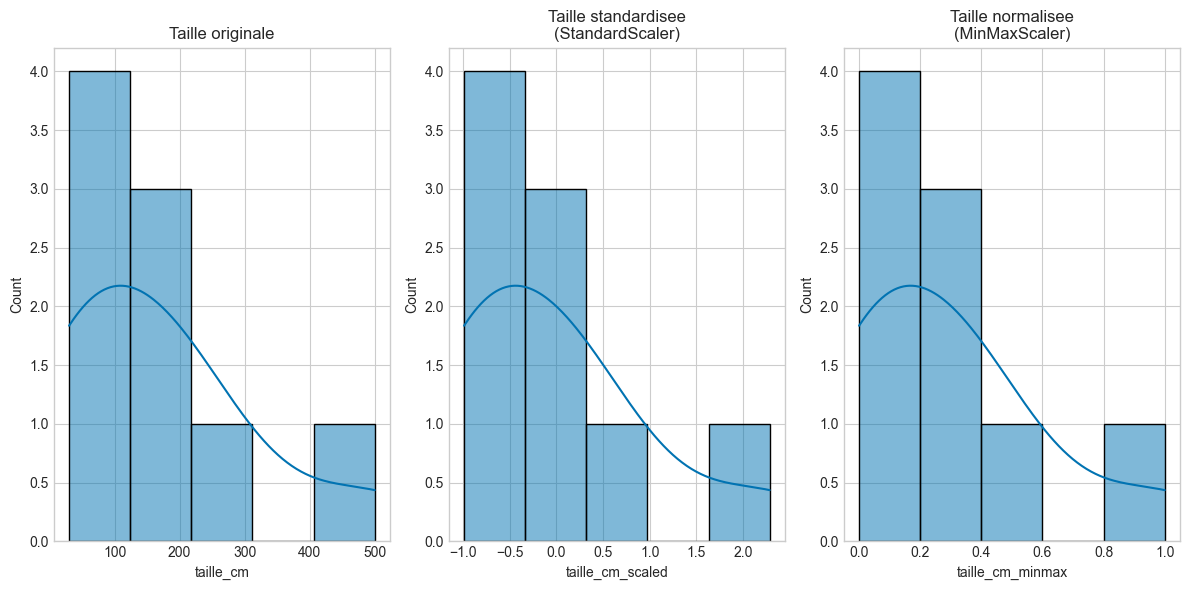

In [24]:
# Visualisation des effets du scaling sur une variable numerique
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.histplot(df_clean['taille_cm'], kde=True)
plt.title('Taille originale')

plt.subplot(1, 3, 2)
sns.histplot(df_clean['taille_cm_scaled'], kde=True)
plt.title('Taille standardisee\n(StandardScaler)')

plt.subplot(1, 3, 3)
sns.histplot(df_clean['taille_cm_minmax'], kde=True)
plt.title('Taille normalisee\n(MinMaxScaler)')

plt.tight_layout()


### 2.3 Feature Engineering (application de fonctions derivees)

Le feature engineering consiste a creer des variables plus informatives a partir des variables existantes.

Exemples classiques:
- ratios
- interactions
- transformations non lineaires (log, sqrt, etc.)



2.3 Feature Engineering (application de fonctions derivees)
--------------------------------------------------------
Nouvelles caracteristiques derivees:
     animal  ratio_poids_taille  densite  vitesse_relative  log_poids
0     Chien               0.417  115.741             0.667      3.258
1      Chat               0.133  148.148             1.000      1.609
2    Cheval               2.500   77.160             0.389      6.111
3     Chien               0.400  160.000             0.700      3.045
4      Chat               0.027    0.782             0.172      1.792
5  Éléphant               2.491   27.679             0.083      6.618
6    Girafe               1.600    6.400             0.100      6.686
7     Chien               0.400  132.231             0.691      3.135
8    Cheval               2.155   62.539             0.404      5.994


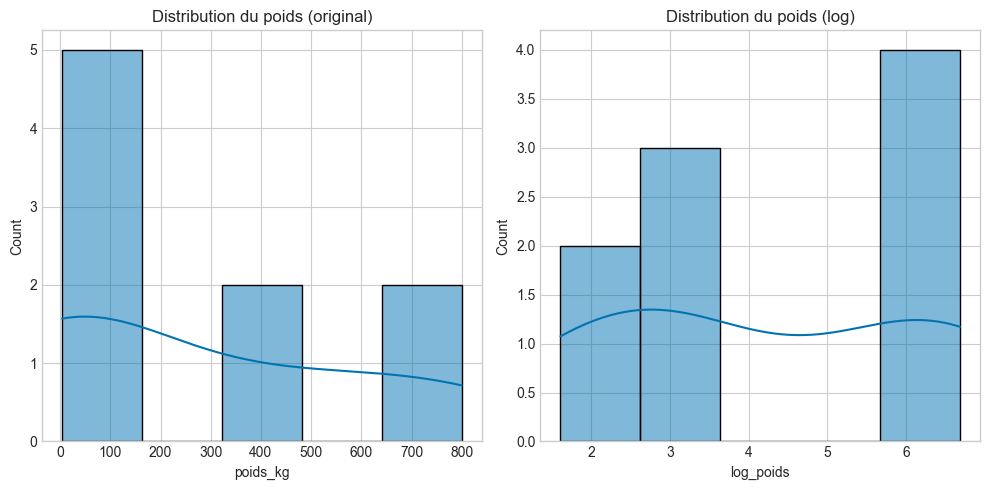

In [25]:
print("\n2.3 Feature Engineering (application de fonctions derivees)")
print("--------------------------------------------------------")

# Exemples de variables derivees
df_clean['ratio_poids_taille'] = df_clean['poids_kg'] / df_clean['taille_cm']
df_clean['densite'] = df_clean['poids_kg'] / (df_clean['taille_cm'] ** 3) * 1_000_000
df_clean['vitesse_relative'] = df_clean['vitesse_kmh'] / df_clean['taille_cm']

# Reduction de l'asymetrie pour une variable tres etalee
df_clean['log_poids'] = np.log1p(df_clean['poids_kg'])

print("Nouvelles caracteristiques derivees:")
print(df_clean[['animal', 'ratio_poids_taille', 'densite', 'vitesse_relative', 'log_poids']].round(3))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_clean['poids_kg'], kde=True)
plt.title('Distribution du poids (original)')

plt.subplot(1, 2, 2)
sns.histplot(df_clean['log_poids'], kde=True)
plt.title('Distribution du poids (log)')

plt.tight_layout()


### 2.4 Discretisation (binning)

La discretisation transforme une variable continue en classes.

Utilite:
- simplifier l'interpretation
- capturer certaines non-linearites
- preparer des modeles ou regles qui exploitent des intervalles


In [40]:
print("\n2.4 Discretisation (binning)")
print("---------------------------")

# Methode 1: discretisation manuelle
print("\nDiscretisation manuelle avec pd.cut:")
df_clean['taille_cat'] = pd.cut(
    df_clean['taille_cm'],
    bins=[0, 50, 100, 200, 1000],
    labels=['Petit', 'Moyen', 'Grand', 'Tres grand'],
    include_lowest=True
)
print(df_clean[['animal', 'taille_cm', 'taille_cat']].sort_values('taille_cm'))



2.4 Discrétisation (binning)
---------------------------

Discrétisation manuelle avec pd.cut:
     animal  taille_cm  taille_cat
1      Chat     30.000       Petit
3     Chien     50.000       Petit
7     Chien     55.000       Moyen
0     Chien     60.000       Moyen
2    Cheval    180.000       Grand
4      Chat    185.625       Grand
8    Cheval    185.625       Grand
5  Éléphant    300.000  Très grand
9  Éléphant    310.000  Très grand
6    Girafe    500.000  Très grand


In [41]:
# Methode 2: discretisation automatique avec KBinsDiscretizer
print("\nDiscretisation automatique avec KBinsDiscretizer:")
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
df_clean['taille_bins'] = discretizer.fit_transform(df_clean[['taille_cm']]).astype(int)
print(df_clean[['animal', 'taille_cm', 'taille_bins']].sort_values('taille_cm'))
print(f"Limites des bins (strategy='quantile'): {discretizer.bin_edges_[0].round(2)}")



Discrétisation automatique avec KBinsDiscretizer:
     animal  taille_cm  taille_bins
1      Chat     30.000          0.0
3     Chien     50.000          0.0
7     Chien     55.000          0.0
0     Chien     60.000          1.0
2    Cheval    180.000          1.0
4      Chat    185.625          2.0
8    Cheval    185.625          2.0
5  Éléphant    300.000          3.0
9  Éléphant    310.000          3.0
6    Girafe    500.000          3.0
Limites des bins (strategy='quantile'): [ 30.    56.25 182.81 271.41 500.  ]


/Users/jika/Desktop/ENSEIGMEMENT/Machine Learing/ALYRA - IA/ai-dev-teaching-hub/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:304: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


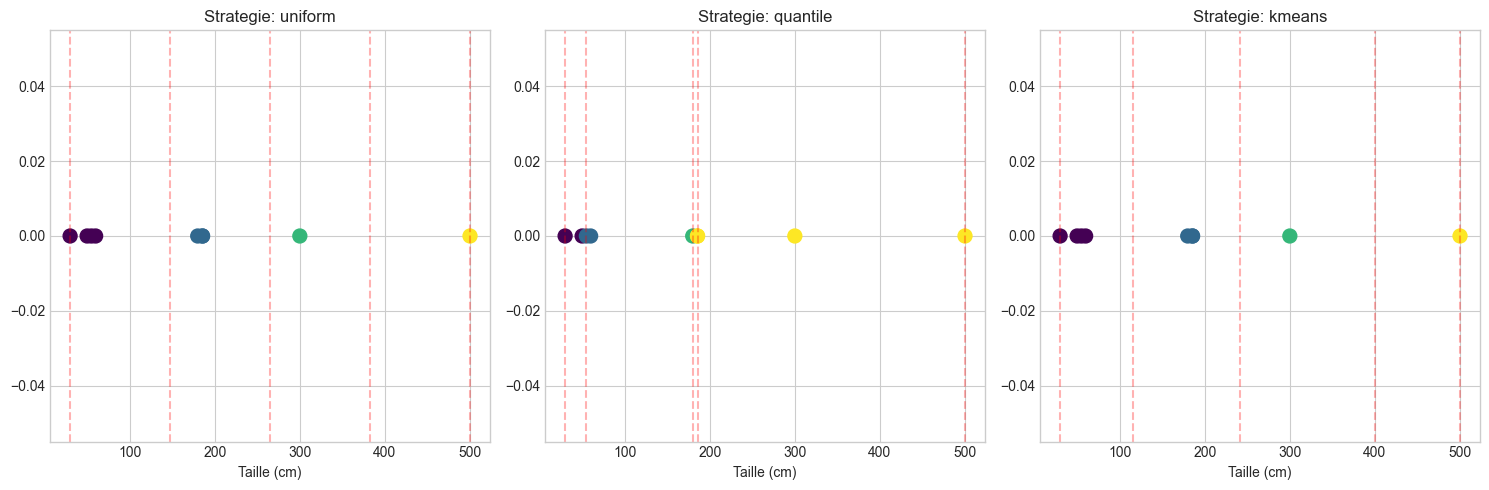

In [26]:
# Comparaison visuelle des strategies de binning
strategies = ['uniform', 'quantile', 'kmeans']
plt.figure(figsize=(15, 5))

for i, strategy in enumerate(strategies):
    discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy=strategy)
    bins = discretizer.fit_transform(df_clean[['taille_cm']])

    plt.subplot(1, 3, i + 1)
    plt.scatter(df_clean['taille_cm'], np.zeros_like(df_clean['taille_cm']), c=bins, cmap='viridis', s=100)
    plt.xlabel('Taille (cm)')
    plt.title(f"Strategie: {strategy}")
    plt.grid(True)

    for edge in discretizer.bin_edges_[0]:
        plt.axvline(x=edge, color='r', linestyle='--', alpha=0.3)

plt.tight_layout()


### 2.5 Pipeline + ColumnTransformer

Ici on assemble un preprocessing reproductible de bout en bout:
- split train/test
- imputation + scaling pour les colonnes numeriques
- one-hot encoding pour les colonnes categorielles

C'est la forme recommandee en production pour eviter les erreurs de sequence et le leakage.


In [ ]:
from sklearn.pipeline import Pipeline

# Variables d'entree / cible (simple demonstration)
X = df[['animal', 'couleur', 'taille_cm', 'poids_kg', 'age_annees']].copy()
y = df['vitesse_kmh'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

numeric_features = ['taille_cm', 'poids_kg', 'age_annees']
categorical_features = ['animal', 'couleur']

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

# Fit sur train uniquement, puis transformation train/test
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print('Shape train apres preprocessing:', X_train_prep.shape)
print('Shape test apres preprocessing:', X_test_prep.shape)

# Exemple optionnel: enchaine directement avec un modele
model = LinearRegression()
model.fit(X_train_prep, y_train)
y_pred = model.predict(X_test_prep)
print('MSE (demo):', round(mean_squared_error(y_test, y_pred), 3))


## ============================================================================
## Resume des techniques de preprocessing
## ============================================================================

1. DATA CLEANING:
   - Imputation simple: mean, median, mode. 
     
   - KNN Imputer: utilise les k voisins les plus proches. 
     
   - Suppression: elimination des lignes ou colonnes avec trop de valeurs manquantes. 
     
   - Traitement des outliers: methodes Z-Score et IQR. 
     

2. PREPROCESSING:
   - Encoding: transformation des variables categorielles en valeurs numeriques. 
     
   - Scaling: normalisation et standardisation des variables numeriques. 
     
   - Feature Engineering: creation de nouvelles caracteristiques derivees. 
     
   - Discretisation: transformation de variables continues en categories. 

> ### Traitement des donnees termine !